In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import confusion_matrix
import itertools

In [19]:
target_names = ["Informative","Noninforamtive"]

max_features = 1000
max_len = 150
embed_size = 200
EMBEDDING_FILE = 'glove.twitter.27B/glove.twitter.27B.200d.txt'
class_weight = {0: 1.48, 1: 0.75}



METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


### ------------------------- DATA -------------------------------------

DATA_PATH = "../data/final_tweets/"

train_df = pd.read_csv(DATA_PATH +'train_df.csv')
valid_df = pd.read_csv(DATA_PATH +'validate_df.csv')
test_df  = pd.read_csv(DATA_PATH + 'test_df.csv')

In [3]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))



def BiLSTM():
    
    sequence_input = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
    x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool]) 
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    preds = Dense(1, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=METRICS)
    
    return model    



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("test.png")
    
    
def plot_summaries(data1, data2, title, ylabel,fname):
    plt.plot(data1)
    plt.plot(data2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(fname +".png")



 # unbalanced dataset - get weights
def get_weights(train_val_df):
    
    neg, pos = np.bincount(train_val_df)
    total = neg + pos
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}

    return class_weight


def prepare_data_train(embeddings_index):

    X_train = train_df['tweet_text']
    Y_train = train_df['text_info']

    X_valid = valid_df['tweet_text']
    Y_valid = valid_df['text_info']

    X_test = test_df['tweet_text']
    Y_test = test_df['text_info']

    tok=text.Tokenizer(num_words=max_features,lower=True)
    tok.fit_on_texts(list(X_train)+list(X_test)+list(X_valid))

    X_test = tok.texts_to_sequences(X_test)
    X_test = sequence.pad_sequences(X_test,maxlen=max_len)

    X_train_f = pd.concat([X_train, X_valid])
    Y_train_f = pd.concat([Y_train, Y_valid])

    train_valid_sequences = tok.texts_to_sequences(X_train_f)
    X_train_f = sequence.pad_sequences(train_valid_sequences,maxlen=max_len)

    word_index = tok.word_index
    #prepare embedding matrix
    num_words = min(max_features, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, X_train_f, Y_train_f, X_test, Y_test 


def get_embeddings():
    embeddings_index = {}
    with open(EMBEDDING_FILE,encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index



def evaluate(X_test_f, Y_test_f, model):
    
    accr = model.evaluate(X_test_f,Y_test_f)
    predictions = model.predict(X_test_f)
    p = 0.5
    cm =  confusion_matrix(Y_test_f, predictions > p)
    plot_confusion_matrix(cm, classes=["Informative","Noninforamtive"], normalize=True,
                      title='Normalized confusion matrix')
    return predictions

In [4]:
embeddings_index = get_embeddings()

In [102]:
embedding_matrix, X_train_matrix, Y_train_f, X_test_f, Y_test_f = prepare_data_train(embeddings_index)
model = BiLSTM()
training_history = model.fit(X_train_matrix,Y_train_f,batch_size=128,epochs=8,\
                             validation_data = (X_test_f, Y_test_f),\
                                                class_weight = class_weight,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)],verbose=1 )

Epoch 1/8
85/85 [==============================] - 39s 462ms/step - loss: 0.4964 - tp: 5800.0000 - fp: 1040.0000 - tn: 2613.0000 - fn: 1394.0000 - accuracy: 0.7756 - precision: 0.8480 - recall: 0.8062 - auc: 0.8384 - val_loss: 0.4033 - val_tp: 1114.0000 - val_fp: 193.0000 - val_tn: 453.0000 - val_fn: 155.0000 - val_accuracy: 0.8183 - val_precision: 0.8523 - val_recall: 0.8779 - val_auc: 0.8856
Epoch 2/8
85/85 [==============================] - 38s 447ms/step - loss: 0.4329 - tp: 5973.0000 - fp: 857.0000 - tn: 2796.0000 - fn: 1221.0000 - accuracy: 0.8084 - precision: 0.8745 - recall: 0.8303 - auc: 0.8794 - val_loss: 0.4123 - val_tp: 1033.0000 - val_fp: 124.0000 - val_tn: 522.0000 - val_fn: 236.0000 - val_accuracy: 0.8120 - val_precision: 0.8928 - val_recall: 0.8140 - val_auc: 0.8945


## EVALUATE MODEL

60/60 [==============================] - 2s 36ms/step - loss: 0.4123 - tp: 1033.0000 - fp: 124.0000 - tn: 522.0000 - fn: 236.0000 - accuracy: 0.8120 - precision: 0.8928 - recall: 0.8140 - auc: 0.8945


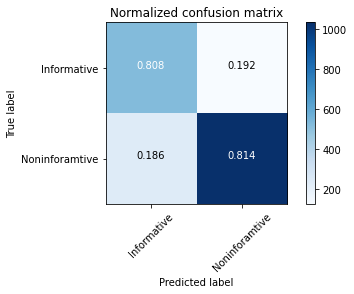

In [103]:
predictions = evaluate(X_test_f, Y_test_f, model)

In [104]:
predictions[predictions >0.5] = 1
predictions[predictions <=0.5] = 0
print(classification_report(Y_test_f, predictions, target_names=target_names))

                precision    recall  f1-score   support

   Informative       0.69      0.81      0.74       646
Noninforamtive       0.89      0.81      0.85      1269

      accuracy                           0.81      1915
     macro avg       0.79      0.81      0.80      1915
  weighted avg       0.82      0.81      0.82      1915



In [ ]:
test_df["predictions"] = predictions
test_df.to_csv("predictions_test_df.csv")

## SAVE MODEL WEIGHTS

In [49]:
model.save('BiLSTM_acc_84')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: BiLSTM_acc_84/assets


## LOAD MODEL

In [5]:
from tensorflow import keras
model_B = keras.models.load_model('BiLSTM_acc_84')

In [6]:
embedding_matrix, X_train_matrix, Y_train_f, X_test_f, Y_test_f = prepare_data_train(embeddings_index)

339/339 [==============================] - 11s 32ms/step - loss: 0.3447 - tp: 6428.0000 - fp: 818.0000 - tn: 2835.0000 - fn: 766.0000 - accuracy: 0.8540 - precision: 0.8871 - recall: 0.8935 - auc: 0.9224


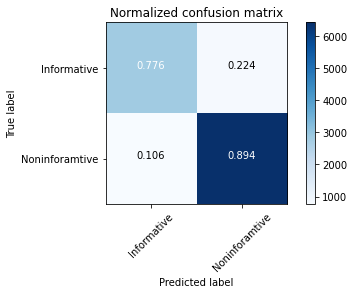

In [8]:
predictions_B = evaluate(X_train_matrix, Y_train_f, model_B)

In [28]:
X_train_f = pd.concat([train_df,valid_df])
X_train_f["predictions"] =predictions_B
X_train_f.to_csv("predictions_full_train_df.csv")

In [29]:
predictions_B[predictions_B >0.5] = 1
predictions_B[predictions_B <=0.5] = 0
print(classification_report(Y_train_f, predictions_B, target_names=target_names))

                precision    recall  f1-score   support

   Informative       0.79      0.78      0.78      3653
Noninforamtive       0.89      0.89      0.89      7194

      accuracy                           0.85     10847
     macro avg       0.84      0.83      0.84     10847
  weighted avg       0.85      0.85      0.85     10847

